In [8]:
import numpy as np
import pandas as pd
import tokenize_uk
import html
import pickle
import collections

from sklearn.model_selection import train_test_split
from fastai.text import *

from data import *

In [9]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [10]:
df = pd.read_csv('../../data/new_all.csv', skiprows=1, header=None, chunksize=2000)


In [11]:
class UKTokenizer():
    def __init__(self):
        self.re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)

    def sub_br(self,x): 
        return self.re_br.sub("\n", x)

    def tokenize(self, x): 
        return tokenize_uk.tokenize_words(self.sub_br(x))

    re_rep = re.compile(r'(\S)(\1{3,})')
    re_word_rep = re.compile(r'(\b\w+\W+)(\1{3,})')

    @staticmethod
    def replace_rep(m):
        TK_REP = 'tk_rep'
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '

    @staticmethod
    def replace_wrep(m):
        TK_WREP = 'tk_wrep'
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '

    @staticmethod
    def do_caps(ss):
        TOK_UP,TOK_SENT,TOK_MIX = ' t_up ',' t_st ',' t_mx '
        res = []
        prev='.'
        re_word = re.compile('\w')
        re_nonsp = re.compile('\S')
        for s in re.findall(r'\w+|\W+', ss):
            res += ([TOK_UP,s.lower()] if (s.isupper() and (len(s)>2))
    #                 else [TOK_SENT,s.lower()] if (s.istitle() and re_word.search(prev))
                    else [s.lower()])
    #         if re_nonsp.search(s): prev = s
        return ''.join(res)

    def proc_text(self, s):
        s = self.re_rep.sub(UKTokenizer.replace_rep, s)
        s = self.re_word_rep.sub(UKTokenizer.replace_wrep, s)
        s = UKTokenizer.do_caps(s)
        s = re.sub(r'([/#])', r' \1 ', s)
        s = re.sub(' {2,}', ' ', s)
        return self.tokenize(s)

    @staticmethod
    def proc_all(ss):
        tok = UKTokenizer()
        return [tok.proc_text(s) for s in ss]

    @staticmethod
    def proc_all_mp(ss):
        ncpus = num_cpus()//2
        with ProcessPoolExecutor(ncpus) as e:
            return sum(e.map(UKTokenizer.proc_all, ss), [])

In [12]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = UKTokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [13]:
texts, labels = get_all(df, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [16]:
text_train, text_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=1234, stratify=labels)

In [17]:
with open('../../data/itos.pkl', 'rb') as f:
    itos = pickle.load(f)
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [18]:
train_clas = np.array([[stoi[o] for o in p] for p in text_train])
val_clas = np.array([[stoi[o] for o in p] for p in text_test])
trn_labels = np.squeeze(np.array(labels_train))
val_labels = np.squeeze(np.array(labels_test))

### Classifier 

In [19]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)

# select our optimizer
# also pick a batch size as big as you can that doesn't run out of memory
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [20]:
trn_ds = TextDataset(train_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)

# sort the docs based on size. 
# validation will be explicitly short -> long
# training, which sorts loosely
trn_samp = SortishSampler(train_clas, key=lambda x: len(train_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))

# then we create our dataloaders as before but with a [sampler] parameter
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData('../../bin', trn_dl, val_dl)

In [21]:
# setup our dropout rates
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

# define our RNN learner
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

# set our learning rate
# we will use discriminative learning rates for different layers
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

# Now we load our language model from before
# but freeze everything except the last layer
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
wd = 1e-7
wd = 0
learn.load_encoder('lm_ukrainian_encoder_v3')
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 799/1025 [12:40<03:35,  1.05it/s, loss=1.69]

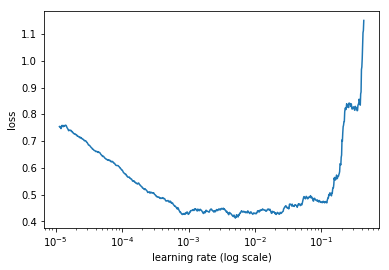

In [22]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [23]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 12/1025 [00:07<10:21,  1.63it/s, loss=0.541]


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      0.390537   0.378388   0.824437  



[array([0.37839]), 0.8244370937790159]

In [24]:
learn.save('clas_0')

In [25]:
learn.load('clas_0')
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.189894   0.122605   0.958171  



[array([0.1226]), 0.9581708449396472]

In [26]:
learn.save('clas_1')

In [27]:
learn.load('clas_1')
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=5, use_clr=(32,10), best_save_name='clas_best', cycle_save_name='clas_cycle')

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.110588   0.088572   0.977786  
 59%|█████▉    | 603/1025 [43:03<30:08,  4.28s/it, loss=0.0747]

KeyboardInterrupt: 

In [ ]:
learn.save('clas_final')